이번 실습에서 해볼 것은 문장을 조각내는 방법입니다.

### 준비물

이번 코스에서는 KoNLPy, 그 중에서도 가장 성능이 준수한 MeCab클래스를 활용해 실습하도록 하겠습니다! (MeCab 클래스는 Windows에서 지원이 되지 않습니다..ㅠㅠ)

KoNLPy 설치하기

- sudo apt-get install g++ openjdk-8-jdk
- bash <(curl -s https://raw.githubusercontent.com/konlpy/konlpy/master/scripts/mecab.sh)
- pip install konlpy

### MeCab 형태소 분석기 사용해보기

In [1]:
from konlpy.tag import Mecab

mecab = Mecab()
print(mecab.morphs('자연어처리가너무재밌어서밥먹는것도가끔까먹어요'))

['자연어', '처리', '가', '너무', '재밌', '어서', '밥', '먹', '는', '것', '도', '가끔', '까먹', '어요']


### 프로젝트에 사용할 라이브러리 import 하기

In [2]:
import os

import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np

%matplotlib inline

### 데이터 다운받기

```bash
$ wget https://github.com/jungyeul/korean-parallel-corpora/blob/master/korean-english-news-v1/korean-english-park.train.tar.gz
$ mkdir -p ~/aiffel/sp_tokenizer/data
$ mv korean-english-park.train.tar.gz ~/aiffel/sp_tokenizer/data
$ cd ~/aiffel/sp_tokenizer/data
$ tar -xzvf korean-english-park.train.tar.gz
```

In [3]:
import os
path_to_file = os.getenv('HOME')+'/aiffel/sp_tokenizer/data/korean-english-park.train.ko'

with open(path_to_file, "r") as f:
    raw = f.read().splitlines()

print("Data Size:", len(raw))

print("Example:")
for sen in raw[0:100][::20]: print(">>", sen)

Data Size: 94123
Example:
>> 개인용 컴퓨터 사용의 상당 부분은 "이것보다 뛰어날 수 있느냐?"
>> 북한의 핵무기 계획을 포기하도록 하려는 압력이 거세지고 있는 가운데, 일본과 북한의 외교관들이 외교 관계를 정상화하려는 회담을 재개했다.
>> "경호 로보트가 침입자나 화재를 탐지하기 위해서 개인적으로, 그리고 전문적으로 사용되고 있습니다."
>> 수자원부 당국은 논란이 되고 있고, 막대한 비용이 드는 이 사업에 대해 내년에 건설을 시작할 계획이다.
>> 또한 근력 운동은 활발하게 걷는 것이나 최소한 20분 동안 뛰는 것과 같은 유산소 활동에서 얻는 운동 효과를 심장과 폐에 주지 않기 때문에, 연구학자들은 근력 운동이 심장에 큰 영향을 미치는지 여부에 대해 논쟁을 해왔다.


In [4]:
x = list(range(100))
print(x[::20])

[0, 20, 40, 60, 80]


내려받은 데이터는 한국어의 형태소 분석과 품사 태깅, 기계 번역 연구를 위해 공개된 데이터입니다. 이번에 사용할 데이터는 한국어-영어 병렬을 이루는 말뭉치 중 한국어 부분으로, 전체 병렬 말뭉치는 후에 번역기를 만들며 사용할 예정입니다!

### 데이터 전처리하기

데이터의 길이의 분포를 알아본뒤 적절한 길이들의 코퍼스만 데이터 분석에 사용하도록 하겠습니다.

문장의 최단 길이: 1
문장의 최장 길이: 377
문장의 평균 길이: 60


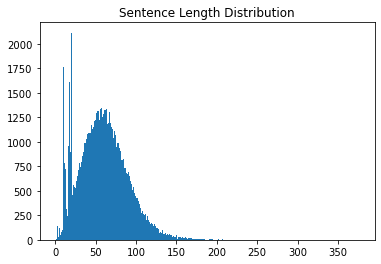

In [5]:
min_len = 999
max_len = 0
sum_len = 0

for sen in raw:
    length = len(sen)
    if min_len > length: min_len = length
    if max_len < length: max_len = length
    sum_len += length

print("문장의 최단 길이:", min_len)
print("문장의 최장 길이:", max_len)
print("문장의 평균 길이:", sum_len // len(raw))

sentence_length = np.zeros((max_len), dtype=np.int)

for sen in raw:
    sentence_length[len(sen)-1] += 1

plt.bar(range(max_len), sentence_length, width=1.0)
plt.title("Sentence Length Distribution")
plt.show()

문장의 길이별로 데이터를 확인하고 그 갯수가 이상치를 보이는 인덱스를 추출하도록 하겠습니다.

In [6]:
def check_sentence_with_length(raw, length):
    count = 0
    
    for sen in raw:
        if len(sen) == length:
            print(sen)
            count += 1
            if count > 100: return

In [7]:
check_sentence_with_length(raw, 1)

’


In [8]:
for idx, _sum in enumerate(sentence_length):
    ## 같은 길이의 문장의 갯수가 1500을 초과하는 인덱스를 추출합니다.
    if _sum > 1500:
        print("Outlier Index:", idx+1)

Outlier Index: 11
Outlier Index: 19
Outlier Index: 21


In [9]:
check_sentence_with_length(raw, 11)

라고 조던이 말했다.
- 모르고 있습니다.
- 네, 보이는군요.
디즈니사만이 아니다.
큰 파티는 아니지요.
의자는 비어 있었다.
이 일은 계속됩니다.
나는 크게 실망했다.
그 이유는 간단하다.
이력서와 자기 소개서
시대가 변하고 있다.
는 돌발질문을 했다.
9. 몇 분간의 명상
하와이, 빅 아일랜드
키스를 잘 하는 방법
키스를 잘 하는 방법
스피어스가 뚱뚱한가?
산 위를 나는 느낌.
세 시간쯤 걸었을까?
(아직 읽고있습니까?
처음에는 장난이었다.
우리는 운이 좋았다.
아기가 숨을 멈출 때
건물 전체 무너져내려
그녀의 아름다운 눈.
대답은 다음과 같다.
"사과할 것이 없다.
폭탄테러가 공포 유발
그는 "잘 모르겠다.
그는 "잘 모르겠다.
그는 "잘 모르겠다.
그는 "잘 모르겠다.
그는 "잘 모르겠다.
그는 "잘 모르겠다.
그는 "잘 모르겠다.
그는 "잘 모르겠다.
그는 "잘 모르겠다.
케냐 야생동물 고아원
경유 1200원대로…
더 내려야 하는 이유
케냐 야생동물 고아원
경유 1200원대로…
더 내려야 하는 이유
케냐 야생동물 고아원
경유 1200원대로…
더 내려야 하는 이유
케냐 야생동물 고아원
경유 1200원대로…
더 내려야 하는 이유
케냐 야생동물 고아원
경유 1200원대로…
더 내려야 하는 이유
케냐 야생동물 고아원
경유 1200원대로…
더 내려야 하는 이유
케냐 야생동물 고아원
경유 1200원대로…
더 내려야 하는 이유
케냐 야생동물 고아원
경유 1200원대로…
더 내려야 하는 이유
케냐 야생동물 고아원
경유 1200원대로…
더 내려야 하는 이유
케냐 야생동물 고아원
경유 1200원대로…
더 내려야 하는 이유
케냐 야생동물 고아원
경유 1200원대로…
더 내려야 하는 이유
케냐 야생동물 고아원
경유 1200원대로…
더 내려야 하는 이유
케냐 야생동물 고아원
경유 1200원대로…
더 내려야 하는 이유
케냐 야생동물 고아원
경유 1200원대로…
더 내려야 하는 이유
케냐 야생동물 고아원
경유 1200원대로…
더 내려야 하는 이유
케냐 야생동물 고아원
경유 1

중복에 대한 처리를 진행하도록 하겠습니다.Python의 기본 자료형 set을 활용합니다.
하지만 변환과정에서 list의 순서가 뒤엉킬수 있으니 번역데이터 처럼 쌍을 이뤄야 하는 경우라면 주의해서 사용해야 합니다.

Data Size: 77591
문장의 최단 길이: 1
문장의 최장 길이: 377
문장의 평균 길이: 64


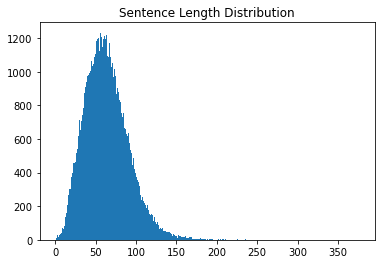

In [10]:
min_len = 999
max_len = 0
sum_len = 0

cleaned_corpus = list(set(raw))  # set를 사용해서 중복을 제거합니다.
print("Data Size:", len(cleaned_corpus))

for sen in cleaned_corpus:
    length = len(sen)
    if min_len > length: min_len = length
    if max_len < length: max_len = length
    sum_len += length

print("문장의 최단 길이:", min_len)
print("문장의 최장 길이:", max_len)
print("문장의 평균 길이:", sum_len // len(cleaned_corpus))

sentence_length = np.zeros((max_len), dtype=np.int)

for sen in cleaned_corpus:   # 중복이 제거된 코퍼스 기준
    sentence_length[len(sen)-1] += 1

plt.bar(range(max_len), sentence_length, width=1.0)
plt.title("Sentence Length Distribution")
plt.show()

길이가 10에서 150사이인 코퍼스만 사용하도록 하겠습니다

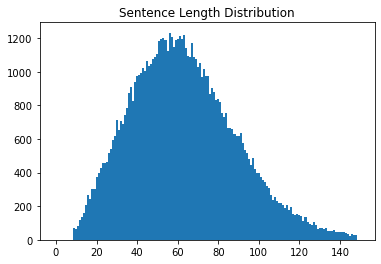

In [11]:
max_len = 150
min_len = 10

# 길이 조건에 맞는 문장만 선택합니다.
filtered_corpus = [s for s in cleaned_corpus if (len(s) < max_len) & (len(s) >= min_len)]

# 분포도를 다시 그려봅니다.
sentence_length = np.zeros((max_len), dtype=np.int)

for sen in filtered_corpus:
    sentence_length[len(sen)-1] += 1

plt.bar(range(max_len), sentence_length, width=1.0)
plt.title("Sentence Length Distribution")
plt.show()

### 공백 기반 토큰화

In [12]:
def tokenize(corpus):  # corpus: Tokenized Sentence's List
    tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='')
    tokenizer.fit_on_texts(corpus)

    tensor = tokenizer.texts_to_sequences(corpus)

    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')

    return tensor, tokenizer

In [13]:
# 정제된 데이터를 공백 기반으로 토큰화하여 저장하는 코드를 직접 작성해 보세요.
split_corpus = []

for kor in filtered_corpus:
    split_corpus.append(kor.split())

In [14]:
split_tensor, split_tokenizer = tokenize(split_corpus)

print("Split Vocab Size:", len(split_tokenizer.index_word))

Split Vocab Size: 237435


In [15]:
for idx, word in enumerate(split_tokenizer.word_index):
    print(idx, ":", word)

    if idx > 10: break

0 : 이
1 : 밝혔다.
2 : 있다.
3 : 말했다.
4 : 수
5 : 있는
6 : 그는
7 : 대한
8 : 위해
9 : 전했다.
10 : 지난
11 : 이번


공백 기반 토큰화는 불필요하게 큰 단어 사전을 가지게 되며 이는 연산량 증가로 이어진다.
또 1번 밝혔다 같이 밝+혔다 로 나눌 수 있다면 다음에 학습하게 될때 의미 단위로 더 자세하게 학습이 가능하게 된다. 따라서 형태소 분석기가 필요한 것이다.

### 형태소 기반 토큰화

In [16]:
# 위에서 사용한 코드를 활용해 MeCab 단어 사전을 만들어보세요. 
# Hint : mecab.morphs()를 사용해서 형태소분석을 합니다.
def mecab_split(sentence):
  return mecab.morphs(sentence)

mecab_corpus = []

for kor in filtered_corpus:
    mecab_corpus.append(mecab_split(kor))

In [17]:
mecab_tensor, mecab_tokenizer = tokenize(mecab_corpus)

print("MeCab Vocab Size:", len(mecab_tokenizer.index_word))

MeCab Vocab Size: 52279


In [18]:
for idx, word in enumerate(mecab_tokenizer.word_index):
    print(idx, ":", word)

    if idx > 10: break

0 : .
1 : 다
2 : 이
3 : 는
4 : 을
5 : 의
6 : 에
7 : 은
8 : 를
9 : 하
10 : 했
11 : 고


앞서 실습했던 공백 기반 단어 사전에 비해 단어 수가 현저히 줄어든 것을 확인하셨을 겁니다. 이는 곧 연산량의 감소로 이어져 더 빠른 학습을 가능케 하고, 심지어 모델이 튜닝해야 하는 매개변수(Parameter) 수가 줄어들어 학습도 더 잘 된답니다

적어도 한국어를 처리할 때는 공백 기반 토큰화를 절대 지양하셔야합니다

다음 스텝에서 배울 SentencePiece같은 Subword 기반 토큰화보다 형태소 분석기가 좋은 성능을 내는 사례들이 종종 있는데요, ETRI에서 발표한 한국어 BERT 모델인 KorBERT가 대표적인 사례 중 하나입니다. 아래 웹페이지를 방문하면 모델의 자세한 구조 뿐 아니라 KorBERT 모델을 5가지 자연어 처리 태스크를 기준으로 평가했던 흥미로운 결과까지 살펴보실 수 있습니다!

http://aiopen.etri.re.kr/service_dataset.php

지금까지 문장을 Tensor로 Encoding하는 과정을 배웠는데요.
후에 모델이 생성한 Tensor를 문장으로 Decoding하는 과정도 필요하겠죠?

1) tokenizer.sequences_to_texts() 함수를 사용하여 Decoding  
2) tokenizer.index_word 를 사용하여 Decoding

두 가지 방법으로 mecab_tensor[100] 을 원문으로 되돌려 보세요! (여기서 띄어쓰기는 고려하지 않습니다!)

In [19]:
# Case 1 : tokenizer.sequences_to_texts()

In [20]:
texts = mecab_tokenizer.sequences_to_texts([mecab_tensor[100]])
print(texts[0])

고머 는 국립 공원 의 산책로 를 이용 하 는 장애 인 들 을 위해 필요 한 정보 를 제공 하 는 웹 사이트 가 필요 했 다고 말 했 다 .


In [21]:
# Case 2 : tokenizer.index_word

In [22]:
sentence = ""

for w in mecab_tensor[100]:
    if w == 0: continue
    sentence += mecab_tokenizer.index_word[w] + " "

print(sentence)

고머 는 국립 공원 의 산책로 를 이용 하 는 장애 인 들 을 위해 필요 한 정보 를 제공 하 는 웹 사이트 가 필요 했 다고 말 했 다 . 


### SentencePiece 사용하기

```
$ pip install sentencepiece
```

### SentencePiece 모델 학습하기

In [23]:
import sentencepiece as spm
import os
temp_file = os.getenv('HOME')+'/aiffel/sp_tokenizer/data/korean-english-park.train.ko.temp'

vocab_size = 8000

with open(temp_file, 'w') as f:
    for row in filtered_corpus:   # 이전 스텝에서 정제했던 corpus를 활용합니다.
        f.write(str(row) + '\n')

spm.SentencePieceTrainer.Train(
    '--input={} --model_prefix=korean_spm --vocab_size={}'.format(temp_file, vocab_size)    
)
#위 Train에서  --model_type = 'unigram'이 디폴트 적용되어 있습니다. --model_type = 'bpe' 로 옵션을 주어 변경할 수 있습니다.

!ls -l korean_spm*

-rw-r--r-- 1 aiffel aiffel 376897 10월 16 10:34 korean_spm.model
-rw-r--r-- 1 aiffel aiffel 146388 10월 16 10:34 korean_spm.vocab


In [24]:
s = spm.SentencePieceProcessor()
s.Load('korean_spm.model')

# SentencePiece를 활용한 sentence -> encoding
tokensIDs = s.EncodeAsIds('아버지가방에들어가신다.')
print(tokensIDs)

# SentencePiece를 활용한 sentence -> encoded pieces
print(s.SampleEncodeAsPieces('아버지가방에들어가신다.',1, 0.0))

# SentencePiece를 활용한 encoding -> sentence 복원
print(s.DecodeIds(tokensIDs))

[1244, 11, 306, 7, 3599, 11, 286, 38, 3]
['▁아버지', '가', '방', '에', '들어', '가', '신', '다', '.']
아버지가방에들어가신다.


### Tokenizer 함수 작성하기

우리는 위에서 훈련시킨 SentencePiece를 활용하여 위 함수와 유사한 기능을 하는 sp_tokenize() 함수를 정의할 겁니다. 하지만 SentencePiece가 동작하는 방식이 단순 토큰화와는 달라 완전히 동일하게는 정의하기 어렵습니다. 그러니 아래 조건을 만족하는 함수를 정의하도록 하겟습니다.

1) 매개변수로 토큰화된 문장의 list를 전달하는 대신 온전한 문장의 list 를 전달합니다.  
2) 생성된 vocab 파일을 읽어와 { <word> : <idx> } 형태를 가지는 word_index 사전과 { <idx> : <word>} 형태를 가지는 index_word 사전을 생성하고 함께 반환합니다.  
3) 리턴값인 tensor 는 앞의 함수와 동일하게 토큰화한 후 Encoding된 문장입니다. 바로 학습에 사용할 수 있게 Padding은 당연히 해야겠죠?  

In [25]:
def sp_tokenize(s, corpus):

    tensor = []

    for sen in corpus:
        tensor.append(s.EncodeAsIds(sen))

    with open("./korean_spm.vocab", 'r') as f:
        vocab = f.readlines()

    word_index = {}
    index_word = {}

    for idx, line in enumerate(vocab):
        word = line.split("\t")[0]

        word_index.update({idx:word})
        index_word.update({word:idx})

    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')

    return tensor, word_index, index_word

In [26]:
#sp_tokenize(s, corpus) 사용예제

my_corpus = ['나는 밥을 먹었습니다.', '그러나 여전히 ㅠㅠ 배가 고픕니다...']
tensor, word_index, index_word = sp_tokenize(s, my_corpus)
print(tensor)

[[1949 5662    5    4 7975 1983    3    0    0    0    0    0    0    0]
 [ 107 1638  101    4    0  419   11    4   14    0 1969    3    3    3]]
